In [1]:
import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from pyDOE import lhs


np.random.seed(1234)
tf.set_random_seed(1234)

In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        self.lb = lb
        self.ub = ub
    
        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u = u
        
        self.layers = layers
        self.nu = nu
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        
                
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)         
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
               
                
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x,t):
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + u*u_x - self.nu*u_xx
        
        return f
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self):
        
        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.u_tf: self.u,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
                
        u_star = self.sess.run(self.u_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]})  
        f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
               
        return u_star, f_star

## Training Neural Net with Initial & Boundary Condition and Physics Laws

In [3]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 3000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('../Data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

In [4]:
X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

In [5]:
X_f_train = np.array([X_f_train[i] for i in range(X_f_train.shape[0]) if (X_f_train[i,1]<0.2) or ((X_f_train[i,1]>0.5) and (X_f_train[i,1]<0.6)) or (abs(X_f_train[i,0])<0.2 and (X_f_train[i,1]<0.8))])

In [6]:
#idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
#X_u_train = X_u_train[idx, :]
#u_train = u_train[idx,:]

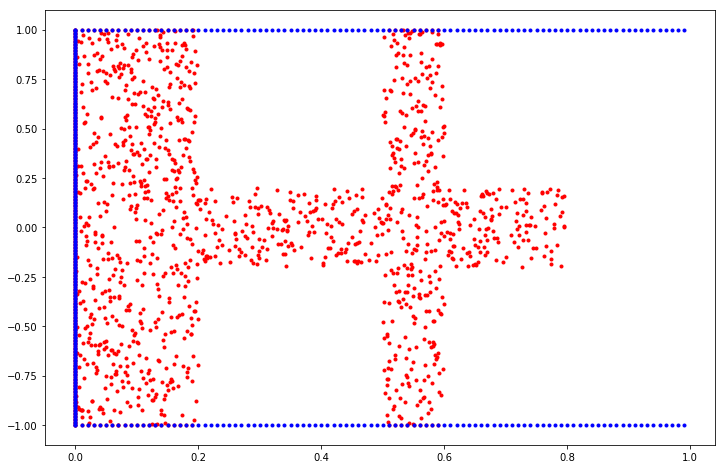

In [7]:
plt.figure(figsize=(12,8))
plt.plot(X_f_train[:,1],X_f_train[:,0],'r.')
plt.plot(X_u_train[:,1],X_u_train[:,0],'b.')


In [8]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

In [9]:
start_time = time.time()                
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

Loss: 0.288917
Loss: 1.46156
Loss: 0.257212
Loss: 0.242747
Loss: 0.327955
Loss: 0.22823
Loss: 0.225227
Loss: 0.221882
Loss: 0.219532
Loss: 0.211482
Loss: 0.203386
Loss: 0.171301
Loss: 0.168279
Loss: 0.160296
Loss: 0.163176
Loss: 0.158438
Loss: 0.157434
Loss: 0.15648
Loss: 0.155189
Loss: 0.152651
Loss: 0.142789
Loss: 0.159624
Loss: 0.139658
Loss: 0.126757
Loss: 0.123574
Loss: 0.122222
Loss: 0.121422
Loss: 0.119614
Loss: 0.115714
Loss: 0.111441
Loss: 0.107427
Loss: 0.104018
Loss: 0.102717
Loss: 0.102319
Loss: 0.101649
Loss: 0.0969957
Loss: 0.0942452
Loss: 0.0930579
Loss: 0.0921494
Loss: 0.0912962
Loss: 0.0905817
Loss: 0.0892809
Loss: 0.087681
Loss: 0.0867826
Loss: 0.0864563
Loss: 0.0859305
Loss: 0.0849779
Loss: 0.0831041
Loss: 0.0819924
Loss: 0.0813905
Loss: 0.0810569
Loss: 0.0806635
Loss: 0.0801418
Loss: 0.0795182
Loss: 0.0789685
Loss: 0.0786941
Loss: 0.0783956
Loss: 0.0781413
Loss: 0.0775708
Loss: 0.0762952
Loss: 0.0742479
Loss: 0.0706098
Loss: 0.069222
Loss: 0.0684515
Loss: 0.0675525


Loss: 0.00453391
Loss: 0.00451684
Loss: 0.00448434
Loss: 0.00640726
Loss: 0.00446736
Loss: 0.00479268
Loss: 0.00444002
Loss: 0.00488584
Loss: 0.00443219
Loss: 0.00436239
Loss: 0.00430697
Loss: 0.00427855
Loss: 0.00426444
Loss: 0.00425547
Loss: 0.0042423
Loss: 0.00422705
Loss: 0.00419465
Loss: 0.00414665
Loss: 0.00410646
Loss: 0.00403723
Loss: 0.00396939
Loss: 0.00393415
Loss: 0.00389335
Loss: 0.00430099
Loss: 0.00387225
Loss: 0.00376547
Loss: 0.00371003
Loss: 0.0036827
Loss: 0.00367498
Loss: 0.00367001
Loss: 0.00366214
Loss: 0.00363058
Loss: 0.00365508
Loss: 0.00361029
Loss: 0.00454532
Loss: 0.00358494
Loss: 0.00353905
Loss: 0.00347066
Loss: 0.00342704
Loss: 0.00339659
Loss: 0.0033699
Loss: 0.00335264
Loss: 0.00333917
Loss: 0.00332172
Loss: 0.00329501
Loss: 0.00326407
Loss: 0.00456098
Loss: 0.0032451
Loss: 0.00323306
Loss: 0.00361765
Loss: 0.00315697
Loss: 0.00315355
Loss: 0.00307127
Loss: 0.00304534
Loss: 0.00301719
Loss: 0.00299976
Loss: 0.00312096
Loss: 0.00298969
Loss: 0.0029692
Lo

Loss: 0.000544107
Loss: 0.000542583
Loss: 0.000540362
Loss: 0.000537966
Loss: 0.000536292
Loss: 0.000533061
Loss: 0.000574359
Loss: 0.000532389
Loss: 0.000530323
Loss: 0.000532153
Loss: 0.000529477
Loss: 0.000528743
Loss: 0.000528095
Loss: 0.000527441
Loss: 0.000526681
Loss: 0.000526423
Loss: 0.000525935
Loss: 0.000525403
Loss: 0.000524763
Loss: 0.000525385
Loss: 0.000524347
Loss: 0.00052377
Loss: 0.000522492
Loss: 0.000521544
Loss: 0.000519744
Loss: 0.000517063
Loss: 0.000515388
Loss: 0.000514204
Loss: 0.000513335
Loss: 0.000511618
Loss: 0.000508415
Loss: 0.000505168
Loss: 0.000502363
Loss: 0.000500629
Loss: 0.00049648
Loss: 0.000493537
Loss: 0.000490694
Loss: 0.000488276
Loss: 0.000486384
Loss: 0.000485226
Loss: 0.000484447
Loss: 0.000483591
Loss: 0.000482535
Loss: 0.000481044
Loss: 0.000478524
Loss: 0.000475544
Loss: 0.000470953
Loss: 0.00046789
Loss: 0.000464061
Loss: 0.000462605
Loss: 0.000460784
Loss: 0.000459551
Loss: 0.000458803
Loss: 0.000458008
Loss: 0.000457564
Loss: 0.00045

Loss: 0.000226194
Loss: 0.000228182
Loss: 0.000225969
Loss: 0.000225576
Loss: 0.000225401
Loss: 0.000225021
Loss: 0.000224728
Loss: 0.000224366
Loss: 0.000224109
Loss: 0.000223798
Loss: 0.000223422
Loss: 0.000222978
Loss: 0.00022261
Loss: 0.000222098
Loss: 0.000221411
Loss: 0.000232269
Loss: 0.00022118
Loss: 0.000220817
Loss: 0.00022043
Loss: 0.000220163
Loss: 0.000219535
Loss: 0.00021918
Loss: 0.000218525
Loss: 0.000217977
Loss: 0.000216936
Loss: 0.000216506
Loss: 0.000215732
Loss: 0.000215034
Loss: 0.000214768
Loss: 0.000214561
Loss: 0.000213723
Loss: 0.0002135
Loss: 0.000212719
Loss: 0.000213178
Loss: 0.000212576
Loss: 0.00021235
Loss: 0.000212026
Loss: 0.000211893
Loss: 0.000211752
Loss: 0.000211573
Loss: 0.000211315
Loss: 0.000211209
Loss: 0.0002111
Loss: 0.000210838
Loss: 0.000210648
Loss: 0.000210318
Loss: 0.000209955
Loss: 0.000209621
Loss: 0.000209386
Loss: 0.000209261
Loss: 0.000209118
Loss: 0.000208865
Loss: 0.000215773
Loss: 0.000208807
Loss: 0.000208448
Loss: 0.000208133
L

Loss: 0.000131142
Loss: 0.000131093
Loss: 0.000130901
Loss: 0.000130767
Loss: 0.000130609
Loss: 0.000130703
Loss: 0.000130565
Loss: 0.000130469
Loss: 0.000130432
Loss: 0.000130394
Loss: 0.000130382
Loss: 0.000130307
Loss: 0.000130271
Loss: 0.000130238
Loss: 0.000130226
Loss: 0.000130165
Loss: 0.000130138
Loss: 0.000129995
Loss: 0.000129936
Loss: 0.000129866
Loss: 0.000129763
Loss: 0.000129599
Loss: 0.00012943
Loss: 0.000129283
Loss: 0.000129092
Loss: 0.000128932
Loss: 0.000128812
Loss: 0.000128698
Loss: 0.000128567
Loss: 0.000128377
Loss: 0.000128095
Loss: 0.000127709
Loss: 0.000129088
Loss: 0.000127633
Loss: 0.00012743
Loss: 0.000127295
Loss: 0.000127216
Loss: 0.00012708
Loss: 0.000127881
Loss: 0.000127058
Loss: 0.000126964
Loss: 0.000126888
Loss: 0.00012682
Loss: 0.000126729
Loss: 0.000126593
Loss: 0.000126466
Loss: 0.000126388
Loss: 0.000126336
Loss: 0.000126301
Loss: 0.00012623
Loss: 0.000126423
Loss: 0.0001262
Loss: 0.000126142
Loss: 0.000126059
Loss: 0.000125952
Loss: 0.000125847

Loss: 8.5682e-05
Loss: 8.558e-05
Loss: 8.55039e-05
Loss: 8.54032e-05
Loss: 8.53003e-05
Loss: 8.51817e-05
Loss: 8.50742e-05
Loss: 8.49576e-05
Loss: 8.48791e-05
Loss: 8.48088e-05
Loss: 8.47047e-05
Loss: 8.45667e-05
Loss: 8.44863e-05
Loss: 8.42868e-05
Loss: 8.52451e-05
Loss: 8.42357e-05
Loss: 8.41108e-05
Loss: 8.40369e-05
Loss: 8.4011e-05
Loss: 8.39617e-05
Loss: 8.39276e-05
Loss: 8.37993e-05
Loss: 8.37031e-05
Loss: 8.35582e-05
Loss: 8.33154e-05
Loss: 8.30864e-05
Loss: 8.29831e-05
Loss: 8.2821e-05
Loss: 8.27136e-05
Loss: 8.2628e-05
Loss: 8.24693e-05
Loss: 8.23099e-05
Loss: 8.21039e-05
Loss: 8.23203e-05
Loss: 8.20337e-05
Loss: 8.1894e-05
Loss: 8.18526e-05
Loss: 8.17832e-05
Loss: 8.16696e-05
Loss: 8.57428e-05
Loss: 8.16507e-05
Loss: 8.15478e-05
Loss: 8.14102e-05
Loss: 8.12354e-05
Loss: 8.10498e-05
Loss: 8.09004e-05
Loss: 8.07412e-05
Loss: 8.06554e-05
Loss: 8.05189e-05
Loss: 8.03953e-05
Loss: 8.01829e-05
Loss: 8.01789e-05
Loss: 8.00472e-05
Loss: 7.99179e-05
Loss: 7.9742e-05
Loss: 7.96428e-05


Loss: 4.54691e-05
Loss: 4.54229e-05
Loss: 4.54052e-05
Loss: 4.53648e-05
Loss: 4.53408e-05
Loss: 4.52794e-05
Loss: 4.52154e-05
Loss: 4.51764e-05
Loss: 4.51349e-05
Loss: 4.51115e-05
Loss: 4.50889e-05
Loss: 4.50354e-05
Loss: 4.49838e-05
Loss: 4.4908e-05
Loss: 4.47861e-05
Loss: 4.46262e-05
Loss: 4.45042e-05
Loss: 4.44635e-05
Loss: 4.43716e-05
Loss: 4.43248e-05
Loss: 4.42454e-05
Loss: 4.44491e-05
Loss: 4.42087e-05
Loss: 4.4116e-05
Loss: 4.40538e-05
Loss: 4.40071e-05
Loss: 4.39601e-05
Loss: 4.38728e-05
Loss: 4.37785e-05
Loss: 4.36892e-05
Loss: 4.35756e-05
Loss: 4.35199e-05
Loss: 4.34388e-05
Loss: 4.33361e-05
Loss: 4.3213e-05
Loss: 4.31185e-05
Loss: 4.30128e-05
Loss: 4.29466e-05
Loss: 4.2881e-05
Loss: 4.28375e-05
Loss: 4.28053e-05
Loss: 4.27493e-05
Loss: 4.28779e-05
Loss: 4.27338e-05
Loss: 4.26971e-05
Loss: 4.26614e-05
Loss: 4.26194e-05
Loss: 4.25603e-05
Loss: 4.24618e-05
Loss: 4.23361e-05
Loss: 4.22113e-05
Loss: 4.21042e-05
Loss: 4.19823e-05
Loss: 4.19576e-05
Loss: 4.1914e-05
Loss: 4.18753e-

Loss: 2.34675e-05
Loss: 2.33981e-05
Loss: 2.34713e-05
Loss: 2.33785e-05
Loss: 2.33577e-05
Loss: 2.33073e-05
Loss: 2.32696e-05
Loss: 2.32085e-05
Loss: 2.31777e-05
Loss: 2.31225e-05
Loss: 2.31085e-05
Loss: 2.30842e-05
Loss: 2.30427e-05
Loss: 2.30564e-05
Loss: 2.30276e-05
Loss: 2.3003e-05
Loss: 2.29635e-05
Loss: 2.29329e-05
Loss: 2.28893e-05
Loss: 2.28138e-05
Loss: 2.30727e-05
Loss: 2.27842e-05
Loss: 2.27101e-05
Loss: 2.26725e-05
Loss: 2.26444e-05
Loss: 2.2602e-05
Loss: 2.25483e-05
Loss: 2.25409e-05
Loss: 2.24907e-05
Loss: 2.24786e-05
Loss: 2.24497e-05
Loss: 2.23935e-05
Loss: 2.23821e-05
Loss: 2.23068e-05
Loss: 2.22738e-05
Loss: 2.22453e-05
Loss: 2.22209e-05
Loss: 2.22056e-05
Loss: 2.21609e-05
Loss: 2.21254e-05
Loss: 2.20892e-05
Loss: 2.20788e-05
Loss: 2.20371e-05
Loss: 2.20025e-05
Loss: 2.19595e-05
Loss: 2.19273e-05
Loss: 2.1883e-05
Loss: 2.33825e-05
Loss: 2.18649e-05
Loss: 2.18167e-05
Loss: 2.18191e-05
Loss: 2.17849e-05
Loss: 2.1736e-05
Loss: 2.16932e-05
Loss: 2.16283e-05
Loss: 2.15894e

Loss: 1.39033e-05
Loss: 1.38619e-05
Loss: 1.38545e-05
Loss: 1.3847e-05
Loss: 1.38458e-05
Loss: 1.3837e-05
Loss: 1.38316e-05
Loss: 1.38246e-05
Loss: 1.38172e-05
Loss: 1.38116e-05
Loss: 1.37939e-05
Loss: 1.37875e-05
Loss: 1.37761e-05
Loss: 1.37707e-05
Loss: 1.37579e-05
Loss: 1.37484e-05
Loss: 1.37339e-05
Loss: 1.37228e-05
Loss: 1.37133e-05
Loss: 1.36977e-05
Loss: 1.36926e-05
Loss: 1.36877e-05
Loss: 1.36809e-05
Loss: 1.367e-05
Loss: 1.36541e-05
Loss: 1.36917e-05
Loss: 1.36485e-05
Loss: 1.36345e-05
Loss: 1.36261e-05
Loss: 1.36173e-05
Loss: 1.36199e-05
Loss: 1.36119e-05
Loss: 1.36058e-05
Loss: 1.35992e-05
Loss: 1.35943e-05
Loss: 1.35828e-05
Loss: 1.35729e-05
Loss: 1.35665e-05
Loss: 1.35516e-05
Loss: 1.35432e-05
Loss: 1.35337e-05
Loss: 1.35179e-05
Loss: 1.35017e-05
Loss: 1.34892e-05
Loss: 1.34842e-05
Loss: 1.34753e-05
Loss: 1.34635e-05
Loss: 1.34502e-05
Loss: 1.3555e-05
Loss: 1.34486e-05
Loss: 1.34385e-05
Loss: 1.34313e-05
Loss: 1.34233e-05
Loss: 1.34152e-05
Loss: 1.34069e-05
Loss: 1.3401e-0

Loss: 1.08763e-05
Loss: 1.08708e-05
Loss: 1.08608e-05
Loss: 1.08517e-05
Loss: 1.08431e-05
Loss: 1.08317e-05
Loss: 1.08221e-05
Loss: 1.08138e-05
Loss: 1.08059e-05
Loss: 1.07993e-05
Loss: 1.07974e-05
Loss: 1.07881e-05
Loss: 1.07832e-05
Loss: 1.07794e-05
Loss: 1.07743e-05
Loss: 1.07697e-05
Loss: 1.07926e-05
Loss: 1.07637e-05
Loss: 1.07585e-05
Loss: 1.07505e-05
Loss: 1.07456e-05
Loss: 1.0739e-05
Loss: 1.07311e-05
Loss: 1.07206e-05
Loss: 1.07126e-05
Loss: 1.07047e-05
Loss: 1.06979e-05
Loss: 1.06918e-05
Loss: 1.06865e-05
Loss: 1.06825e-05
Loss: 1.06787e-05
Loss: 1.06736e-05
Loss: 1.06704e-05
Loss: 1.06665e-05
Loss: 1.06613e-05
Loss: 1.06565e-05
Loss: 1.06564e-05
Loss: 1.06531e-05
Loss: 1.06479e-05
Loss: 1.06426e-05
Loss: 1.06357e-05
Loss: 1.06299e-05
Loss: 1.06373e-05
Loss: 1.06279e-05
Loss: 1.06226e-05
Loss: 1.06171e-05
Loss: 1.06131e-05
Loss: 1.06036e-05
Loss: 1.06004e-05
Loss: 1.05954e-05
Loss: 1.05919e-05
Loss: 1.05848e-05
Loss: 1.0568e-05
Loss: 1.05495e-05
Loss: 1.05281e-05
Loss: 1.0508

Loss: 8.74502e-06
Loss: 8.74746e-06
Loss: 8.74139e-06
Loss: 8.7386e-06
Loss: 8.73448e-06
Loss: 8.73109e-06
Loss: 8.72681e-06
Loss: 8.72083e-06
Loss: 8.71603e-06
Loss: 8.71129e-06
Loss: 8.70874e-06
Loss: 8.70468e-06
Loss: 8.70103e-06
Loss: 8.6964e-06
Loss: 8.69129e-06
Loss: 8.70965e-06
Loss: 8.68834e-06
Loss: 8.68059e-06
Loss: 8.67365e-06
Loss: 8.66868e-06
Loss: 8.66269e-06
Loss: 8.81853e-06
Loss: 8.66207e-06
Loss: 8.65539e-06
Loss: 8.64734e-06
Loss: 8.63845e-06
Loss: 8.63327e-06
Loss: 8.63078e-06
Loss: 8.62744e-06
Loss: 8.62565e-06
Loss: 8.6244e-06
Loss: 8.62256e-06
Loss: 8.62087e-06
Loss: 8.61835e-06
Loss: 8.61559e-06
Loss: 8.61318e-06
Loss: 8.61169e-06
Loss: 8.61023e-06
Loss: 8.60799e-06
Loss: 8.6041e-06
Loss: 8.60082e-06
Loss: 8.59848e-06
Loss: 8.59407e-06
Loss: 8.59042e-06
Loss: 8.58538e-06
Loss: 8.57826e-06
Loss: 8.57686e-06
Loss: 8.56946e-06
Loss: 8.56741e-06
Loss: 8.56564e-06
Loss: 8.56312e-06
Loss: 8.56102e-06
Loss: 8.55841e-06
Loss: 8.55484e-06
Loss: 8.55195e-06
Loss: 8.54853e

Loss: 6.89111e-06
Loss: 6.88884e-06
Loss: 6.88431e-06
Loss: 6.8832e-06
Loss: 6.87924e-06
Loss: 6.87659e-06
Loss: 6.87269e-06
Loss: 6.86898e-06
Loss: 6.86602e-06
Loss: 6.86911e-06
Loss: 6.8643e-06
Loss: 6.86226e-06
Loss: 6.85979e-06
Loss: 6.85683e-06
Loss: 6.8541e-06
Loss: 6.85084e-06
Loss: 6.84834e-06
Loss: 6.84863e-06
Loss: 6.84678e-06
Loss: 6.84481e-06
Loss: 6.84328e-06
Loss: 6.84931e-06
Loss: 6.84253e-06
Loss: 6.84123e-06
Loss: 6.84011e-06
Loss: 6.83839e-06
Loss: 6.8362e-06
Loss: 6.83342e-06
Loss: 6.83043e-06
Loss: 6.83209e-06
Loss: 6.82824e-06
Loss: 6.82472e-06
Loss: 6.82116e-06
Loss: 6.81803e-06
Loss: 6.81386e-06
Loss: 6.80802e-06
Loss: 6.80172e-06
Loss: 6.79757e-06
Loss: 6.79054e-06
Loss: 6.78703e-06
Loss: 6.77777e-06
Loss: 6.79444e-06
Loss: 6.77631e-06
Loss: 6.76869e-06
Loss: 6.76194e-06
Loss: 6.75645e-06
Loss: 6.75161e-06
Loss: 6.74557e-06
Loss: 6.74052e-06
Loss: 6.76272e-06
Loss: 6.73702e-06
Loss: 6.72914e-06
Loss: 6.71746e-06
Loss: 6.7105e-06
Loss: 6.70823e-06
Loss: 6.69947e-

Loss: 5.53899e-06
Loss: 5.53833e-06
Loss: 5.52799e-06
Loss: 5.5241e-06
Loss: 5.52201e-06
Loss: 5.51926e-06
Loss: 5.51182e-06
Loss: 5.50773e-06
Loss: 5.50356e-06
Loss: 5.49968e-06
Loss: 5.49667e-06
Loss: 5.49111e-06
Loss: 5.48811e-06
Loss: 5.48627e-06
Loss: 5.48389e-06
Loss: 5.48284e-06
Loss: 5.48133e-06
Loss: 5.48023e-06
Loss: 5.47918e-06
Loss: 5.47682e-06
Loss: 5.47406e-06
Loss: 5.47194e-06
Loss: 5.47061e-06
Loss: 5.46944e-06
Loss: 5.46869e-06
Loss: 5.46638e-06
Loss: 5.46455e-06
Loss: 5.4664e-06
Loss: 5.46331e-06
Loss: 5.46211e-06
Loss: 5.46052e-06
Loss: 5.45897e-06
Loss: 5.45732e-06
Loss: 5.45629e-06
Loss: 5.45358e-06
Loss: 5.45238e-06
Loss: 5.44889e-06
Loss: 5.44741e-06
Loss: 5.44836e-06
Loss: 5.44612e-06
Loss: 5.44377e-06
Loss: 5.44126e-06
Loss: 5.43876e-06
Loss: 5.43557e-06
Loss: 5.43419e-06
Loss: 5.42999e-06
Loss: 5.42813e-06
Loss: 5.4278e-06
Loss: 5.42686e-06
Loss: 5.42464e-06
Loss: 5.42461e-06
Loss: 5.42008e-06
Loss: 5.4172e-06
Loss: 5.41314e-06
Loss: 5.50828e-06
Loss: 5.41229e

Loss: 4.83782e-06
Loss: 4.83492e-06
Loss: 4.83283e-06
Loss: 4.84302e-06
Loss: 4.83185e-06
Loss: 4.83114e-06
Loss: 4.82954e-06
Loss: 4.82879e-06
Loss: 4.8272e-06
Loss: 4.82593e-06
Loss: 4.82406e-06
Loss: 4.8231e-06
Loss: 4.82239e-06
Loss: 4.82115e-06
Loss: 4.82021e-06
Loss: 4.81882e-06
Loss: 4.81685e-06
Loss: 4.81467e-06
Loss: 4.81402e-06
Loss: 4.81288e-06
Loss: 4.81175e-06
Loss: 4.8106e-06
Loss: 4.80844e-06
Loss: 4.80691e-06
Loss: 4.80538e-06
Loss: 4.80426e-06
Loss: 4.80228e-06
Loss: 4.80073e-06
Loss: 4.80043e-06
Loss: 4.80009e-06
Loss: 4.79947e-06
Loss: 4.79854e-06
Loss: 4.79793e-06
Loss: 4.79702e-06
Loss: 4.7964e-06
Loss: 4.7942e-06
Loss: 4.79198e-06
Loss: 4.79205e-06
Loss: 4.79132e-06
Loss: 4.79025e-06
Loss: 4.78892e-06
Loss: 4.78666e-06
Loss: 4.78327e-06
Loss: 4.7811e-06
Loss: 4.77939e-06
Loss: 4.77723e-06
Loss: 4.77501e-06
Loss: 4.77277e-06
Loss: 4.77097e-06
Loss: 4.76875e-06
Loss: 4.7651e-06
Loss: 4.76395e-06
Loss: 4.76273e-06
Loss: 4.76146e-06
Loss: 4.76044e-06
Loss: 4.75835e-06

Loss: 4.27063e-06
Loss: 4.26851e-06
Loss: 4.26704e-06
Loss: 4.26411e-06
Loss: 4.26256e-06
Loss: 4.26497e-06
Loss: 4.26128e-06
Loss: 4.26029e-06
Loss: 4.25944e-06
Loss: 4.2586e-06
Loss: 4.25841e-06
Loss: 4.25753e-06
Loss: 4.25638e-06
Loss: 4.25509e-06
Loss: 4.25399e-06
Loss: 4.2527e-06
Loss: 4.25146e-06
Loss: 4.24971e-06
Loss: 4.24698e-06
Loss: 4.24464e-06
Loss: 4.2427e-06
Loss: 4.24042e-06
Loss: 4.2384e-06
Loss: 4.23892e-06
Loss: 4.2371e-06
Loss: 4.23625e-06
Loss: 4.23566e-06
Loss: 4.23537e-06
Loss: 4.23465e-06
Loss: 4.23366e-06
Loss: 4.23283e-06
Loss: 4.23218e-06
Loss: 4.2314e-06
Loss: 4.23044e-06
Loss: 4.22917e-06
Loss: 4.23243e-06
Loss: 4.229e-06
Loss: 4.22779e-06
Loss: 4.22527e-06
Loss: 4.22265e-06
Loss: 4.22073e-06
Loss: 4.21892e-06
Loss: 4.21647e-06
Loss: 4.21516e-06
Loss: 4.2144e-06
Loss: 4.2134e-06
Loss: 4.21276e-06
Loss: 4.21035e-06
Loss: 4.20851e-06
Loss: 4.20621e-06
Loss: 4.20319e-06
Loss: 4.20044e-06
Loss: 4.19922e-06
Loss: 4.19818e-06
Loss: 4.19764e-06
Loss: 4.19691e-06
Lo

Loss: 3.66061e-06
Loss: 3.66015e-06
Loss: 3.6599e-06
Loss: 3.6591e-06
Loss: 3.65848e-06
Loss: 3.65725e-06
Loss: 3.65575e-06
Loss: 3.65382e-06
Loss: 3.65252e-06
Loss: 3.65057e-06
Loss: 3.64885e-06
Loss: 3.64736e-06
Loss: 3.64847e-06
Loss: 3.64655e-06
Loss: 3.64507e-06
Loss: 3.64349e-06
Loss: 3.64245e-06
Loss: 3.64164e-06
Loss: 3.64324e-06
Loss: 3.64146e-06
Loss: 3.64085e-06
Loss: 3.64046e-06
Loss: 3.63986e-06
Loss: 3.63939e-06
Loss: 3.63857e-06
Loss: 3.63735e-06
Loss: 3.64096e-06
Loss: 3.63688e-06
Loss: 3.63566e-06
Loss: 3.63492e-06
Loss: 3.63433e-06
Loss: 3.63341e-06
Loss: 3.63234e-06
Loss: 3.63192e-06
Loss: 3.63135e-06
Loss: 3.63075e-06
Loss: 3.62993e-06
Loss: 3.62927e-06
Loss: 3.6292e-06
Loss: 3.62813e-06
Loss: 3.62792e-06
Loss: 3.62756e-06
Loss: 3.62718e-06
Loss: 3.62681e-06
Loss: 3.6267e-06
Loss: 3.62578e-06
Loss: 3.62561e-06
Loss: 3.62463e-06
Loss: 3.62395e-06
Loss: 3.62336e-06
Loss: 3.6228e-06
Loss: 3.62242e-06
Loss: 3.6224e-06
Loss: 3.62208e-06
Loss: 3.62101e-06
Loss: 3.62027e-0

In [10]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

Error u: 2.339958e-01


In [11]:
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

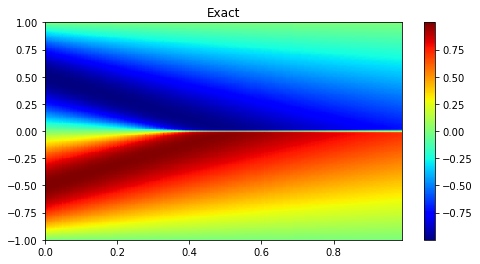

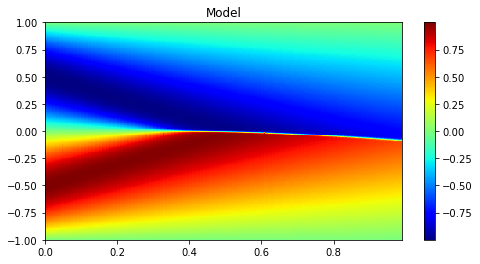

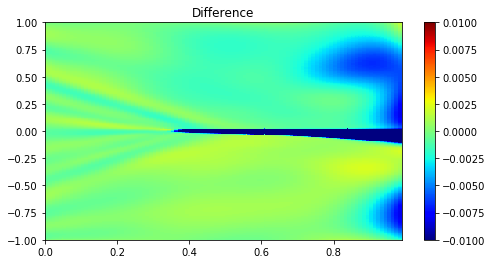

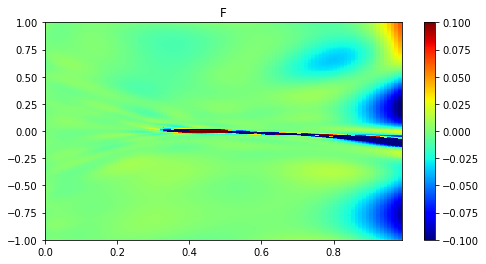

In [12]:
plt.figure(figsize=(8,4))
plt.pcolor(T, X, Exact,cmap='jet')
plt.colorbar()
plt.title('Exact')

plt.figure(figsize=(8,4))
plt.pcolor(T, X, U_pred,cmap='jet')
plt.colorbar()
plt.title('Model')

plt.figure(figsize=(8,4))
plt.pcolor(T, X, U_pred-Exact,cmap='jet', vmin=-.01, vmax=.01)
plt.colorbar()
plt.title('Difference')


plt.figure(figsize=(8,4))
plt.pcolor(T, X, F_pred,cmap='jet', vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.title('F')



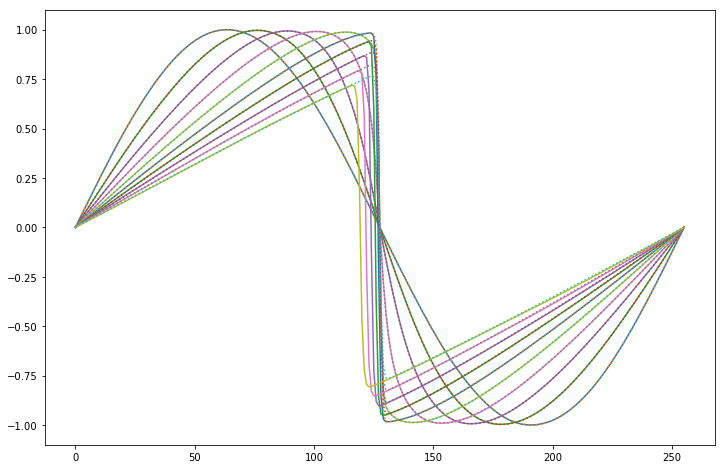

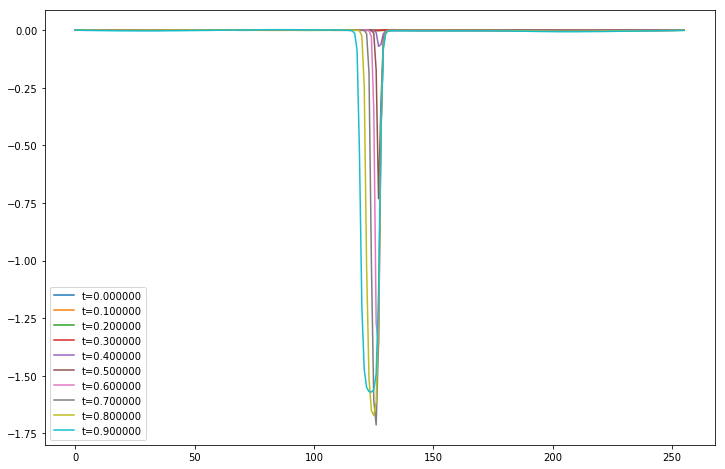

In [13]:
plt.figure(figsize=(12,8))
for tmp_i in range(0,t.shape[0],10):
    tmp_t = t[tmp_i]
    tmp_x_t = np.concatenate((x,np.full(x.shape,tmp_t)),1)
    tmp_u_pred, _ = model.predict(tmp_x_t)
    
    plt.plot(tmp_u_pred)
    plt.plot(Exact[tmp_i,:],':')
    
plt.figure(figsize=(12,8))
for tmp_i in range(0,t.shape[0],10):
    tmp_t = t[tmp_i]
    tmp_u_pred = U_pred[tmp_i,:]
    plt.plot(tmp_u_pred-Exact[tmp_i,:],label='t=%f' % tmp_t)
plt.legend()


In [14]:
X_star_new = np.concatenate([X_star,X_star,X_star])
X_star_new[25600:,1]=X_star_new[25600:,1]+1
X_star_new[51200:,1]=X_star_new[51200:,1]+1

In [15]:
u_pred_new, f_pred_new = model.predict(X_star_new)
U_pred_new = np.reshape(u_pred_new,(len(t)*3,len(x)))


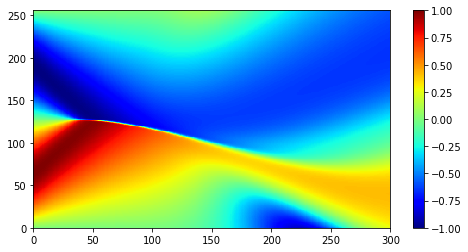

In [16]:
plt.figure(figsize=(8,4))
plt.pcolor(U_pred_new.T,cmap='jet', vmin=-1,vmax=1)
plt.colorbar()